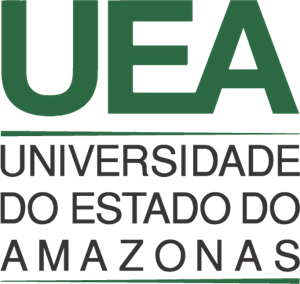

- Módulo: Machine Learning Aplicado I

- Equipe: EAD

- Alunos:
  
  - Andrew da Silva Santos
  - Eberth Felipe Castro da Cruz
  - Eduardo Amorim de Araújo




#Coding

##General Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, SCORERS
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.utils import resample

# Configs
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

Install Extra Libraries

In [2]:
# install
!pip install shap
!pip install xgboost
!pip install catboost
!pip install lightgbm

import xgboost
import catboost
import lightgbm as lgb

     |████████████████████████████████| 356 kB 14.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491639 sha256=3ce51de2feaa1eb73e78b3c831c845a00c67298c7d8622f1f0dd732c95157d79
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
     |████████████████████████████████| 69.2 MB 5.0 kB/s 


##Get data from Kaggle API
Reference: https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

###Install Kaggle and Import API

In [3]:
!pip install kaggle

###Get Files

In [4]:
# Kaggle API reference: https://github.com/Kaggle/kaggle-api
def import_kaggle_api_key():
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  from kaggle.api.kaggle_api_extended import KaggleApi

def get_data_from_competition():
  # Kaggle competition link
  # https://www.kaggle.com/c/aml-t2-fw/data
  !kaggle competitions download -c aml-t2-fw
  !ls -la ./
  !unzip ./Dados_Teste.csv.zip
  !unzip ./Dados_Treino.csv.zip
  !ls -la ./

Run this function to import your API.

In order to get you key, got to **Kaggle** > Account > Create New API Token

Import `kaggle.json` file

In [5]:
import_kaggle_api_key()

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [6]:
get_data_from_competition()

# download em ambiente local
# !kaggle competitions download -c aml-t2-fw
# !unzip ./aml-t2-fw.zip


 44% 9.00M/20.3M [00:00<00:00, 19.5MB/s]
100% 20.3M/20.3M [00:00<00:00, 34.5MB/s]
  0% 0.00/114k [00:00<?, ?B/s]
100% 114k/114k [00:00<00:00, 97.2MB/s]
  0% 0.00/2.30M [00:00<?, ?B/s]
100% 2.30M/2.30M [00:00<00:00, 78.8MB/s]
  0% 0.00/28.2k [00:00<?, ?B/s]
100% 28.2k/28.2k [00:00<00:00, 15.6MB/s]
total 23268
drwxr-xr-x 1 root root     4096 Aug  4 17:52 .
drwxr-xr-x 1 root root     4096 Aug  4 17:47 ..
drwxr-xr-x 4 root root     4096 Jul 16 13:19 .config
-rw-r--r-- 1 root root  2410135 Aug  4 17:52 Dados_Teste.csv.zip
-rw-r--r-- 1 root root 21243109 Aug  4 17:52 Dados_Treino.csv.zip
-rw-r--r-- 1 root root    28910 Aug  4 17:52 Dicionario_de_Dados.csv
drwxr-xr-x 1 root root     4096 Jul 16 13:20 sample_data
-rw-r--r-- 1 root root   117176 Aug  4 17:52 Template_Submissao.csv
Archive:  ./Dados_Teste.csv.zip
  inflating: Dados_Teste.csv         
Archive:  ./Dados_Treino.csv.zip
  inflating: Dados_Treino.csv        
total 108712
drwxr-xr-x 1 root root     4096 Aug  4 17:52 .
drwxr-xr-x 1 roo

##Datasets


###Initial view

In [229]:
df_dados_teste = pd.read_csv('./Dados_Teste.csv')
df_dados_treino = pd.read_csv('./Dados_Treino.csv')
df_dict_dados = pd.read_csv('./Dicionario_de_Dados.csv')
df_template_sub = pd.read_csv('./Template_Submissao.csv')

In [ ]:
def explore_dataset(df_aux):
  delimiter = '--------------------'
  print(df_aux.shape)
  print(delimiter)
  print(round(df_aux.describe(), 2))
  print(delimiter)
  df_aux.info(verbose=True)

Dados de Treino

In [ ]:
df_dados_treino.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1,12.7,NaN,NaN,95.0,31.0,95.0,31.0,118.0,72.0,NaN,NaN,120.0,38.0,120.0

In [ ]:
explore_dataset(df_dados_treino)

(117141, 180)
--------------------
       encounter_id  hospital_id        age        bmi  elective_surgery  \
count     117141.00    117141.00  112653.00  113106.00         117141.00   
mean      213013.98       106.22      62.01      29.12              0.19   
std        38128.78        63.48      16.83       8.28              0.39   
min       147001.00         1.00       0.00      14.84              0.00   
25%       179951.00        50.00      52.00      23.60              0.00   
50%       213051.00       112.00      64.00      27.57              0.00   
75%       246063.00       165.00      75.00      32.82              0.00   
max       279000.00       204.00      89.00      67.81              1.00   

          height     icu_id  pre_icu_los_days  readmission_status     weight  \
count  115286.00  117141.00         117141.00            117141.0  114021.00   
mean      169.60     662.94              0.84                 0.0      83.81   
std        10.84     304.33             

Dados de Teste

In [ ]:
df_dados_teste.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,231640,42,35.0,29.060607,0,Caucasian,F,169.0,Emergency Department,Accident & Emergency,1044,admit,Med-Surg ICU,0.161806,0,83.0,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,91.0,120.0,NaN,0,68.0,NaN,NaN,NaN,NaN,39.0,NaN,34.7,1708.3872,1,NaN,NaN,NaN,86.0,54.0,86.0,54.0,120.0,72.0,NaN,NaN,97.333333,68.333333,97.333333,68.333333,44.0,15.0,100.0,94.0,NaN,NaN,140.0,92.0,140.0,92.0,38.7,34.7,NaN,NaN,83.0,67.0,83.0,67.0,80.0,73.0,NaN,NaN,97.333333,79.0,97.333333,79.0,15.0,15.0,100.0,100.0,NaN,NaN,126.0,103.0,126.0,103.0,34.7,34.7,2.7,2.7,NaN,NaN,8.0,8.0,NaN,NaN,0.87,0.87,108.0,91.0,21.0,21.0,12.6,12.6,37.0,37.0,NaN,NaN,NaN,NaN,259.0,259.0,3.5,3.5,142.0,142.0,18.60,18.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,220057,100,84.0,23.128938,0,Caucasian,F,170.2,Emergency Department,Accident & Emergency,490,admit,Med-Surg ICU,0.040972,0,67.0,NaN,301.0,403.01,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,4.0,232.0,107.0,NaN,0,57.0,NaN,NaN,NaN,NaN,25.0,NaN,36.0,852.59

In [ ]:
explore_dataset(df_dados_teste)

(13016, 179)
--------------------
       encounter_id  hospital_id       age       bmi  elective_surgery  \
count      13016.00     13016.00  12516.00  12561.00          13016.00   
mean      212882.75       105.04     61.87     29.02              0.19   
std        37940.12        63.46     16.80      8.09              0.39   
min       147000.00         1.00      0.00     14.84              0.00   
25%       180537.25        47.00     52.00     23.61              0.00   
50%       212676.50       110.00     64.00     27.55              0.00   
75%       245433.25       163.00     75.00     32.61              0.00   
max       278994.00       204.00     89.00     67.81              1.00   

         height    icu_id  pre_icu_los_days  readmission_status    weight  \
count  12794.00  13016.00          13016.00             13016.0  12673.00   
mean     169.64    657.86              0.82                 0.0     83.66   
std       10.81    303.61              2.31                 0.0     

###ETL

Divisão da classe alvo

In [61]:
df_dados_treino['diabetes_mellitus'].value_counts()

0    91807
1    25334
Name: diabetes_mellitus, dtype: int64

In [62]:
# def split_data_for_xy(df, col_begin, col_end, target):
#   split_X = df.loc[:,col_begin:col_end].to_numpy()
#   split_y = df[target].to_numpy()
#   return split_X, split_y 

def split_data_for_xy_columns(df, col_begin, col_end, target):
  split_X = df.loc[:,col_begin:col_end]
  split_y = df.loc[:,target]
  return split_X, split_y 

####Pré-processamento de dados de treino e teste

In [172]:
#Transform fields from Object to int
def transform_fields(df, fields):
  label_encoder = LabelEncoder()
  for field in fields:
    df[field] = label_encoder.fit_transform(list(df[field].values))
  return df

#Treat numeric values from dataframe
def str_to_num(df_aux, index):
  for i in index:
    col_name = df_aux.columns[i]
    # df_aux[col_name] = df_aux[col_name].str.replace('.', '')
    # df_aux[col_name] = df_aux[col_name].str.replace(',', '.')
    df_aux[col_name] = pd.to_numeric(df_aux[col_name])
  return df_aux

#Scale numeric values
def apply_scale_for_num(df):
  columns_num = df.loc[:,'age':'solid_tumor_with_metastasis'].select_dtypes(include=['int64', 'float64']).columns
  # columns_num = df.loc[:,'gcs_eyes_apache':'solid_tumor_with_metastasis'].select_dtypes(include=['int64', 'float64']).columns
  df_aux = df[columns_num]

  min_max_scaler = MinMaxScaler().fit(df_aux.values)
  df_aux = min_max_scaler.transform(df_aux.values)
  df[columns_num] = df_aux
  return df

In [230]:
fields_to_tranform = ['ethnicity', 'gender']
df_dados_teste = transform_fields(df_dados_teste, fields_to_tranform)
df_dados_treino = transform_fields(df_dados_treino, fields_to_tranform)

# Change field type
df_dados_teste = str_to_num(df_dados_teste, [3])
df_dados_treino = str_to_num(df_dados_treino, [3])

In [231]:
#Remove columns
rm_columns = [
              # 'bmi', 
              'hospital_id','hospital_admit_source', 
              'icu_admit_source', 'icu_id', 
              'pre_icu_los_days', 'icu_stay_type', 'icu_type', 
              # 'apache_2_diagnosis', 
              'readmission_status', 'height'
              # 'apache_3j_diagnosis'
              ]

df_dados_teste.drop(columns=rm_columns, inplace=True)
df_dados_treino.drop(columns=rm_columns, inplace=True)

In [232]:
# First try: Replace NaN values with 0
# Second try: Replace NaN values with mean
# Third try: Replace NaN values with median

# Forth try: drop nan
# df_dados_teste = df_dados_teste.dropna().reset_index(drop=True)
# df_dados_treino = df_dados_treino.dropna().reset_index(drop=True)

df_dados_teste = df_dados_teste.fillna(df_dados_teste.median())
df_dados_treino = df_dados_treino.fillna(df_dados_treino.median())



In [233]:
df_dados_teste = apply_scale_for_num(df_dados_teste.copy())
df_dados_treino = apply_scale_for_num(df_dados_treino.copy())
df_dados_teste

,encounter_id,age,bmi,elective_surgery,ethnicity,gender,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,231640,0.393258,0.268372,0.0,0.333333,0.0,0.301221,0.500000,0.101449,0.319394,0.0,0.0,0.013193,0.121951,0.060662,0.367089,1.000000,1.0,1.0,1.00,0.092907,0.608108,0.482955,0.0,0.17500,0.288312,0.288312,0.156317,0.634607,0.625000,0.512195,0.342105,0.195991,1.0,0.213808,0.270833,0.488095,0.336134,0.532468,0.336134,0.532468,0.521008,0.473684,0.221831,0.512821,0.301075,0.514815,0.308540,0.514815,0.384615,0.217391,1.00,0.94,0.352679,0.506173,0.352113,0.428571,0.352113,0.428427,0.750000,0.475554,0.333333,0.423529,0.433962,0.494505,0.429907,0.489130,0.288136,0.342593,0.210960,0.500000,0.416667,0.443396,0.423977,0.443396,0.102041,0.127119,1.00,1.00,0.386740,0.483670,0.344595,0.354610,0.344595,0.352113,0.213115,0.281250,0.441176,0.470588,0.011019,0.011019,0.032787,0.045417,0.478261,0.562500,0.049211,0.059142,0.065056,0.227451,0.321429,0.43750,0.557692,0.640351,0.533762,0.616519,0.056884,0.057394,0.072165,0.074830,0.415771,0.446187,0.166667,0.323529,0.542857,0.694444,0.387701,0.442522,0.555556,0.555556,0.011396,0.011396,0.114504,0.114504,0.465517,0.498753,0.061202,0.061382,0.077039,0.105096,0.515152,0.515152,0.495935,0.495935,0.492997,0.488889,0.056884,0.057394,0.096045,0.090808,0.279646,0.277876,0.340426,0.347826,0.581395,0.558140,0.255

####Escolha e execute uma ou mais formas de tratamento dos ***datasets*** abaixo:


1.   Balanceamento de classe majoritária
2.   Utilização de categorias dos atributos informados no dicionário de dados
3.   Seleção dos melhores atributos




##### Balanceamento de dados de treino

Escolha as opções que deseja realizar para balanceamento dos dados:


*   Diminuição de dados de pacientes que não possuem diabetes; 
*   Aumento de dados de pacientes que possuem diabetes; 



0    91807
1    25334
Name: diabetes_mellitus, dtype: int64


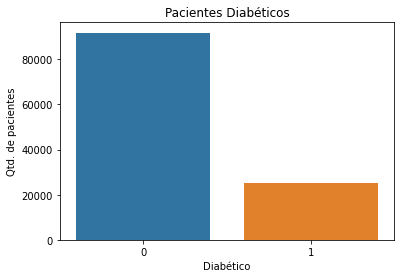

In [177]:
print(df_dados_treino['diabetes_mellitus'].value_counts())
plt.figure(figsize = (6,4))
ax = sns.countplot(x = 'diabetes_mellitus', 
                  data = df_dados_treino)

ax.set_title('Pacientes Diabéticos')
ax.set_xlabel('Diabético')
ax.set_ylabel('Qtd. de pacientes')
# plt.xticks(rotation=45)
plt.show()

###### Diminuindo Classe **Majoritária**

Escoha a quantidade máxima de não diabéticos para treinamento dos modelos

In [ ]:
#@title Quantidade de não diabéticos
max_no_diabetes =  80000#@param {type:"integer"}

# ref: https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
df_majority = df_dados_treino[df_dados_treino.diabetes_mellitus==0]
df_minority = df_dados_treino[df_dados_treino.diabetes_mellitus==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=max_no_diabetes,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print(df_downsampled.diabetes_mellitus.value_counts())
df_dados_treino = df_downsampled

0    80000
1    25334
Name: diabetes_mellitus, dtype: int64


###### Aumentando Classe **Minoritária**

Escoha a quantidade de pacientes diabéticos para treinamento dos modelos

In [234]:
#@title Quantidade de pacientes diabéticos
max_num_diabetes =  91807#@param {type:"integer"}

# ref: https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
df_majority = df_dados_treino[df_dados_treino.diabetes_mellitus==0]
df_minority = df_dados_treino[df_dados_treino.diabetes_mellitus==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=max_num_diabetes,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
 
# Display new class counts
print(df_upsampled.diabetes_mellitus.value_counts())
df_dados_treino = df_upsampled

1    91807
0    91807
Name: diabetes_mellitus, dtype: int64


###### View Dataframe

In [111]:
df_dados_treino.head()

,encounter_id,age,bmi,elective_surgery,ethnicity,gender,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
89181,188553,0.696629,0.574821,0.0,0.333333,0.5,0.679032,0.739130,0.383117,0.274442,0.0,1.0,0.009967,0.480315,0.635063,0.0,1.0,1.0,0.0,1.0,0.172039,0.724719,0.517510,0.0,0.615,0.0,0.0,0.0,0.0,0.166667,0.905063,0.944584,0.125843,0.0,0.100437,0.000000,0.000000,0.636364,0.544444,0.636364,0.544444,0.627119,0.457143,0.00000,0.000000,0.657609,0.544643,0.668508,0.544643,0.206522,0.11,0.99,0.93,0.000000,0.000000,0.732759,0.6125,0.732759,0.6125,0.959900,0.981481,0.000000,0.000000,0.594406,0.752212,0.590278,0.745614,0.676829,0.770833,0.000000,0.000000,0.642424,0.768116,0.650307,0.768116,0.338983,0.074074,0.97,0.92,0.000000,0.000000,0.762332,0.876289,0.762332,0.871795,0.969620,0.974555,0.739130,0.755556,0.009967,0.010345,0.484127,0.539393,0.824074,0.864078,0.639064,0.714437,0.194763,0.357639,0.675,0.692308,0.494186,0.508982,0.516505,0.532,0.154719,0.195854,0.000000,0.000000,0.256410,0.269082,0.700000,0.844828,0.905063,0.934641,0.099826,0.112475,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154719,0.195854,0.0,0.0,0.00000,0.00000,0.000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

##### Test category 
Filter some categories to test models

In [ ]:
keep_categories = ['identifier', 'labs', 'labs blood gas', 'Target Variable']
keep_columns = df_dict_dados[df_dict_dados['Category'].isin(keep_categories)]
keep_columns_train = keep_columns['Variable Name'].values
keep_columns_test = np.delete(keep_columns_train, len(keep_columns_train)-1)

# reset main dataframes
df_dados_teste = pd.read_csv('./Dados_Teste.csv')
df_dados_treino = pd.read_csv('./Dados_Treino.csv')

df_dados_teste = df_dados_teste[keep_columns_test]
df_dados_treino = df_dados_treino[keep_columns_train]

#remove columns
rm_columns = ['hospital_id']
df_dados_teste.drop(columns=rm_columns, inplace=True)
df_dados_treino.drop(columns=rm_columns, inplace=True)

#Replace NaN values with 0
df_dados_teste = df_dados_teste.fillna(0)
df_dados_treino = df_dados_treino.fillna(0)

#transform fields
column_begin = 'd1_albumin_max'
column_end = 'h1_pao2fio2ratio_min'
df_dados_teste = apply_scale_for_num(df_dados_teste.copy(), cl_begin=column_begin, cl_end=column_end)
df_dados_treino = apply_scale_for_num(df_dados_treino.copy(), cl_begin=column_begin, cl_end=column_end)

df_dados_teste

#####Verify best attributes

In [237]:
#@title Inform the number of attributes that you want
num_attributes =  25#@param {type:"integer"}

# ref: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

X_aux, y_aux = split_data_for_xy_columns(df_dados_treino,'age', 'solid_tumor_with_metastasis', target='diabetes_mellitus')

bestfeatures = SelectKBest(score_func=chi2, k=num_attributes)
fit = bestfeatures.fit(X_aux,y_aux)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_aux.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(num_attributes,'Score'))  #print X best features

                         Specs        Score
96              d1_glucose_max  4538.689626
19              glucose_apache  3166.827803
10                  arf_apache  2250.468139
126             h1_glucose_max  1000.699232
90                  d1_bun_max   776.110277
127             h1_glucose_min   768.953596
94           d1_creatinine_max   688.178645
91                  d1_bun_min   678.235241
12                  bun_apache   650.341140
95           d1_creatinine_min   632.702101
1                          bmi   627.945927
13           creatinine_apache   558.654417
5                       weight   554.559534
97              d1_glucose_min   327.730279
110           d1_potassium_max   149.287869
100          d1_hemaglobin_max   131.311912
54                d1_sysbp_max   107.516052
56    d1_sysbp_noninvasive_max   105.787439
102          d1_hematocrit_max    87.906200
0                          age    84.871321
63               h1_diasbp_min    79.899334
101          d1_hemaglobin_min  

In [238]:
col_filtered = featureScores.nlargest(num_attributes,'Score')['Specs'].tolist()
list_aux = col_filtered
print(len(list_aux))
list_aux.insert(0,'encounter_id')

df_dados_teste = df_dados_teste.loc[:, df_dados_teste.columns.isin(list_aux)]

list_aux.insert(len(list_aux), 'diabetes_mellitus')
print(len(list_aux))
df_dados_treino = df_dados_treino.loc[:, df_dados_treino.columns.isin(list_aux)]
print(df_dados_treino.shape)

25
27
(183614, 27)


In [239]:
df_dados_treino.head()

,encounter_id,age,bmi,weight,arf_apache,bun_apache,creatinine_apache,glucose_apache,d1_sysbp_max,d1_sysbp_noninvasive_max,h1_diasbp_min,h1_diasbp_noninvasive_min,d1_bun_max,d1_bun_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_potassium_max,h1_bun_max,h1_bun_min,h1_glucose_max,h1_glucose_min,diabetes_mellitus
89181,188553,0.696629,0.455664,0.594980,1.0,0.463415,0.625000,0.114347,0.563380,0.563380,0.692308,0.684783,0.467213,0.526842,0.627669,0.705548,0.085502,0.274510,0.163462,0.280702,0.199357,0.500000,0.106870,0.106870,0.127349,0.146497,1
70331,231908,1.000000,0.222213,0.261194,0.0,0.081301,0.228860,0.282294,0.316901,0.316901,0.362637,0.358696,0.081967,0.099918,0.227484,0.258355,0.230483,0.247059,0.259615,0.368421,0.340836,0.404762,0.076336,0.076336,0.086472,0.114650,1
78996,194216,0.921348,0.272036,0.348033,0.0,0.121951,0.061581,0.285867,0.535211,0.535211,0.505495,0.500000,0.262295,0.299755,0.079851,0.093381,0.466543,0.298039,0.394231,0.491228,0.372990,0.190476,0.106870,0.106870,0.199671,0.229299,1
97485,216683,0.842697,0.325287,0.466079,0.0,0.243902,0.192096,0.489548,0.626761,0.626761,0.439560,0.434783,0.163934,0.190753,0.160631,0.183650,0.260223,0.705882,0.586538,0.666667,0.556270,0.476190,0.106870,0.106870,0.127349,0.146497,1
68692,212364,0.617978,0.134612,0.132293,0.0,0.276423,0.267463,0.226907,0.732394,0.732394,0.681319,0.673913,0.278689,0.317922,0.266481,0.301933,0.172862,0.403922,0.115385,0.236842,0.096463,0.047619,0.106870,0.106870,0.121061,0.149682,1


In [240]:
df_dados_teste.head()

,encounter_id,age,bmi,weight,arf_apache,bun_apache,creatinine_apache,glucose_apache,d1_sysbp_max,d1_sysbp_noninvasive_max,h1_diasbp_min,h1_diasbp_noninvasive_min,d1_bun_max,d1_bun_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_potassium_max,h1_bun_max,h1_bun_min,h1_glucose_max,h1_glucose_min
0,231640,0.393258,0.268372,0.301221,0.0,0.121951,0.060662,0.092907,0.352113,0.352113,0.494505,0.489130,0.032787,0.045417,0.049211,0.059142,0.065056,0.227451,0.557692,0.640351,0.533762,0.166667,0.114504,0.114504,0.077039,0.105096
1,220057,0.943820,0.156390,0.192673,0.0,0.121951,0.060662,0.344828,0.570423,0.570423,0.175824,0.173913,0.090164,0.109002,0.024141,0.031127,0.295539,0.329412,0.538462,0.622807,0.559486,0.190476,0.114504,0.114504,0.127349,0.148089
2,238466,0.685393,0.529138,0.630936,0.0,0.121951,0.060662,0.234054,0.464789,0.464789,0.505495,0.500000,0.098361,0.118085,0.035283,0.043578,0.180297,0.376471,0.807692,0.868421,0.839228,0.238095,0.114504,0.114504,0.133638,0.162420
3,214794,0.966292,0.206731,0.200814,0.0,0.121951,0.055147,0.126854,0.373239,0.373239,0.230769,0.228261,0.122951,0.145336,0.061281,0.072630,0.126394,0.301961,0.067308,0.149123,0.183280,0.428571,0.114504,0.114504,0.080183,0.108280
4,255804,0.426966,0.510167,0.559023,0.0,0.081301,0.042279,0.280507,0.098592,0.098592,0.483516,0.478261,0.081967,0.099918,0.038997,0.047728,0.228625,0.290196,0.490385,0.526316,0.472669,0.500000,0.114504,0.114504,0.149361,0.160828


##Machine Learning Algorithms

Algoritmos utilizados para prever a presença de Diabetes em pacientes

### Utility Functions to help the process

In [76]:
def print_model_result(model, X_tr, X_ts, y_tr, y_ts):
  print(f'Acurácia (Treino): {round(accuracy_score(y_tr, model.predict(X_tr)), 2)}')
  print(f'Acurácia (Teste): {round(accuracy_score(y_ts, model.predict(X_ts)), 2)}')
  print(classification_report(y_ts, model.predict(X_ts), target_names=['NO', 'YES']))
  plot_confusion_matrix(model, X_ts, y_ts)

def plot_confusion_matrix(model, X_ts, y_ts):
  fig, ax = plt.subplots(figsize=(10,8))
  cm = confusion_matrix(y_ts, model.predict(X_ts), labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=pd.Series(model.classes_).map({0: 'No', 1: 'Yes'}))
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  plt.show()

def get_samples_for_train_test(X, y, div_size, random):
  X_tr, X_ts, y_tr, y_ts = train_test_split(X, 
                                            y,
                                            shuffle = True,
                                            stratify = y,
                                            test_size=div_size, 
                                            random_state=random)
  print('Amostras de treino:')
  print(f' * X_train: {X_tr.shape}')
  print(f' * y_train: {y_tr.shape}')

  print('Amostras de teste:')
  print(f' * X_test: {X_ts.shape}')
  print(f' * y_test: {y_ts.shape}')
  return X_tr, X_ts, y_tr, y_ts

def create_knn_model(neighbors, X_tr, X_ts, y_tr, y_ts):
  model = KNeighborsClassifier(n_neighbors=neighbors)
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

def create_tree_model(depth, X_tr, X_ts, y_tr, y_ts):
  tree_model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)

  tree_model.fit(X_tr, y_tr)
  print_model_result(tree_model, X_tr, X_ts, y_tr, y_ts)
  return tree_model

def create_logistic_model(X_tr, X_ts, y_tr, y_ts):
  logistic_model = LogisticRegression()
  logistic_model.fit(X_tr, y_tr)
  print_model_result(logistic_model, X_tr, X_ts, y_tr, y_ts)
  return logistic_model

def create_random_forest_model(depth, estimators, X_tr, X_ts, y_tr, y_ts):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

In [37]:
def upload_submit(path, msg):
  !kaggle competitions submit -c aml-t2-fw -f '{path}' -m f"Descrição: {msg}"

def send_submit(df, msg):
  now = datetime.now()
  timestamp = datetime.timestamp(now)
  df.to_csv(f'submit_{timestamp}.csv', index=False)
  upload_submit(f'submit_{timestamp}.csv', msg)


def update_df_template(df, df_result_test):
  df['diabetes_mellitus'] = df_result_test.loc[df_result_test['encounter_id'] == df['encounter_id']]['predict']
  return df

def get_dataframe_for_submission(model, prediction_type = None):
  df_result = df_dados_teste.copy()
  print('### Copy Template ###')
  df_result_template = df_template_sub.copy()
  print('### Filter encounter_id column ###\n### Predict ... ###')
  if ( prediction_type is not None ):
    print('### Hard... ###')
    df_result['predict'] = model.predict( df_result[df_result.columns[1:]] )
  else:
    print('### Proba... ###')
    df_result['predict'] = model.predict_proba( df_result[df_result.columns[1:]] )[:,1]
  print('### Create dataframe with result... ###')
  df_result_template = df_result_template.apply(lambda x: update_df_template(x, df_result), axis=1)
  df_result_template = df_result_template.astype({'encounter_id': 'int64'})
  return df_result_template

def view_result(df_result_view):
  df_result_view = round(df_result_view, 2)
  plt.figure(figsize = (16,10))
  ax = sns.countplot(x = 'diabetes_mellitus', 
                    data = df_result_view)

  ax.set_title('Previsão de Pacientes Diabéticos')
  ax.set_xlabel('Diabético')
  ax.set_ylabel('Qtd. de pacientes')
  plt.xticks(rotation=45)
  plt.show()

### Treinamento dos Modelos

The fields which you will filter must be customized based on the treatment applied before.

In [241]:
#Check fields in dataset before run
X, y = split_data_for_xy_columns(df_dados_treino,'age', 'h1_glucose_min', target='diabetes_mellitus')

In [242]:
X_train, X_test, y_train, y_test = get_samples_for_train_test(X, y, div_size=0.30, random=1)

Amostras de treino:
 * X_train: (128529, 25)
 * y_train: (128529,)
Amostras de teste:
 * X_test: (55085, 25)
 * y_test: (55085,)


#### KNN - k vizinhos mais próximos
Treino do Modelo utilizando a algoritmo KNN

****************** KNN ******************
Acurácia (Treino): 0.77
Acurácia (Teste): 0.7
              precision    recall  f1-score   support

          NO       0.67      0.79      0.73      7601
         YES       0.74      0.61      0.67      7600

    accuracy                           0.70     15201
   macro avg       0.71      0.70      0.70     15201
weighted avg       0.71      0.70      0.70     15201



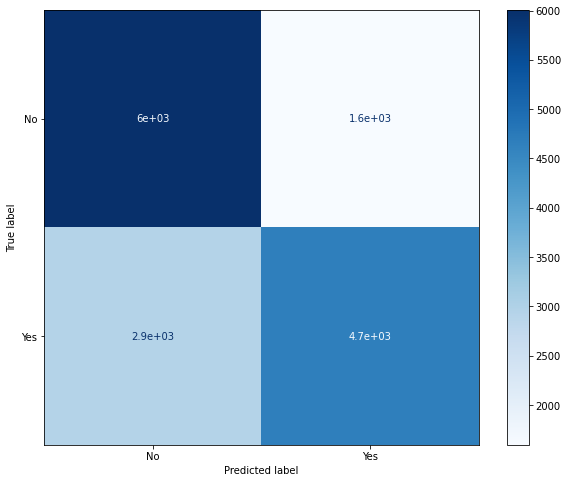

In [ ]:
print('****************** KNN ******************')

knn_model = create_knn_model(neighbors=6, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


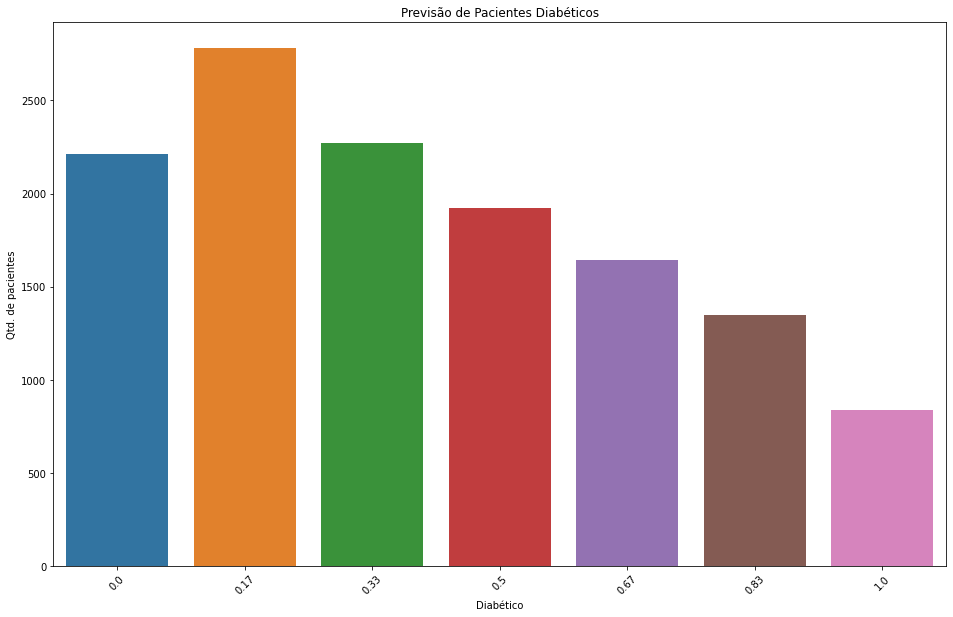

In [ ]:
result_knn = get_dataframe_for_submission(knn_model, prediction_type=None)
view_result(result_knn)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_knn, 'Teste 4 knn')

100%|████████████████████████████████████████| 263k/263k [00:03<00:00, 71.9kB/s]
400 - Bad Request


#### Decision Tree
Treino do Modelo utilizando a algoritmo Árvore de decisão

****************** ARVORE ******************
Acurácia (Treino): 0.81
Acurácia (Teste): 0.8
              precision    recall  f1-score   support

          NO       0.85      0.90      0.88     27543
         YES       0.55      0.43      0.48      7600

    accuracy                           0.80     35143
   macro avg       0.70      0.67      0.68     35143
weighted avg       0.79      0.80      0.79     35143



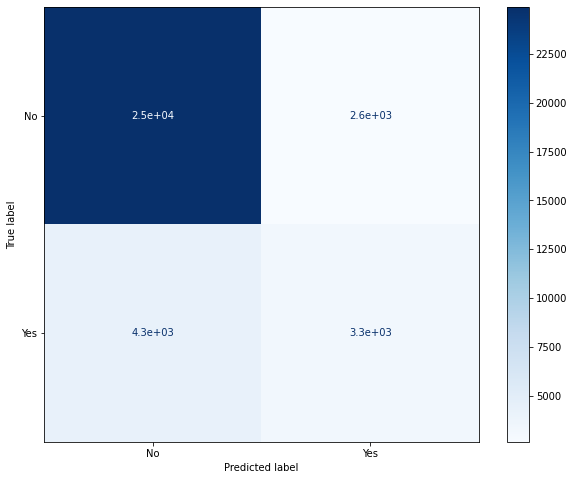

In [ ]:
print('****************** ARVORE ******************')

tree_model = create_tree_model(depth=6, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


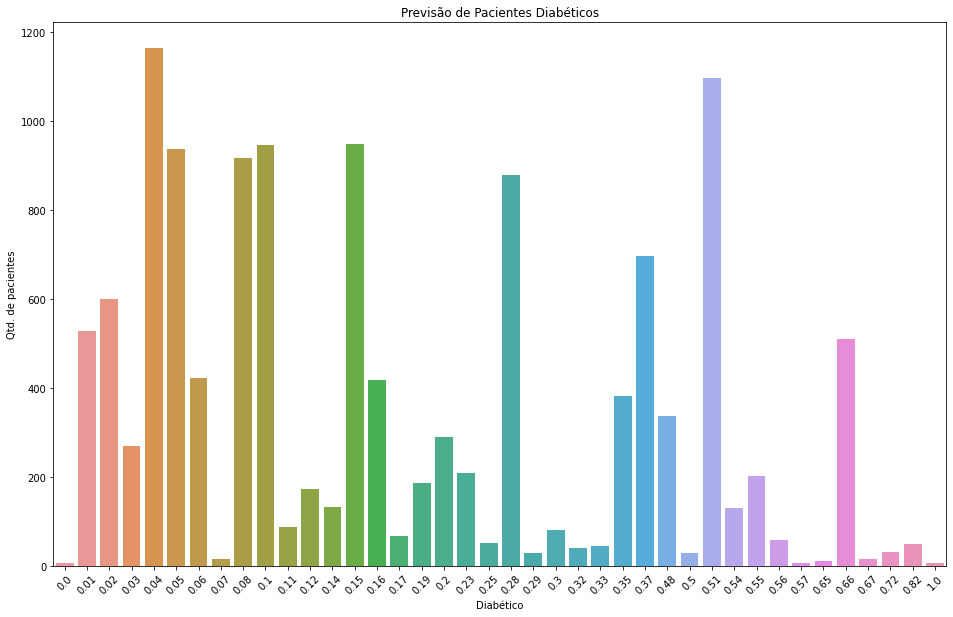

In [ ]:
# gera o df para submissão com base no template
result_tree = get_dataframe_for_submission(tree_model)
view_result(result_tree)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_tree, 'Teste 5 decision tree')

100%|█████████████████████████████████████████| 339k/339k [00:03<00:00, 106kB/s]
400 - Bad Request


#### Logistic Regression
Treino do Modelo utilizando a algoritmo de Regressão Logística

****************** Regressão Logística ******************
Acurácia (Treino): 0.78
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.78      1.00      0.88     22952
         YES       0.37      0.01      0.02      6334

    accuracy                           0.78     29286
   macro avg       0.58      0.50      0.45     29286
weighted avg       0.69      0.78      0.69     29286



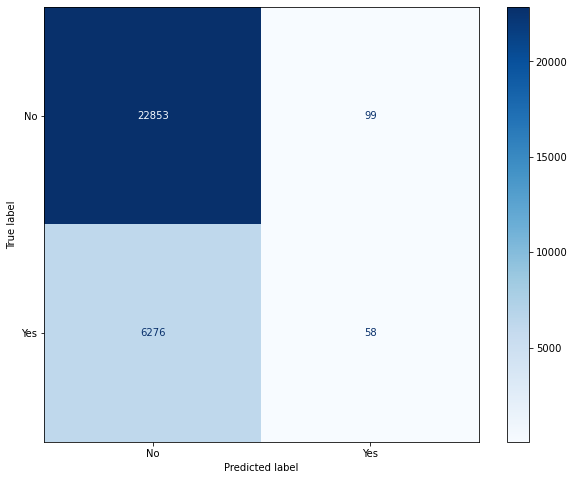

In [ ]:
print('****************** Regressão Logística ******************')

logistic_model = create_logistic_model(X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

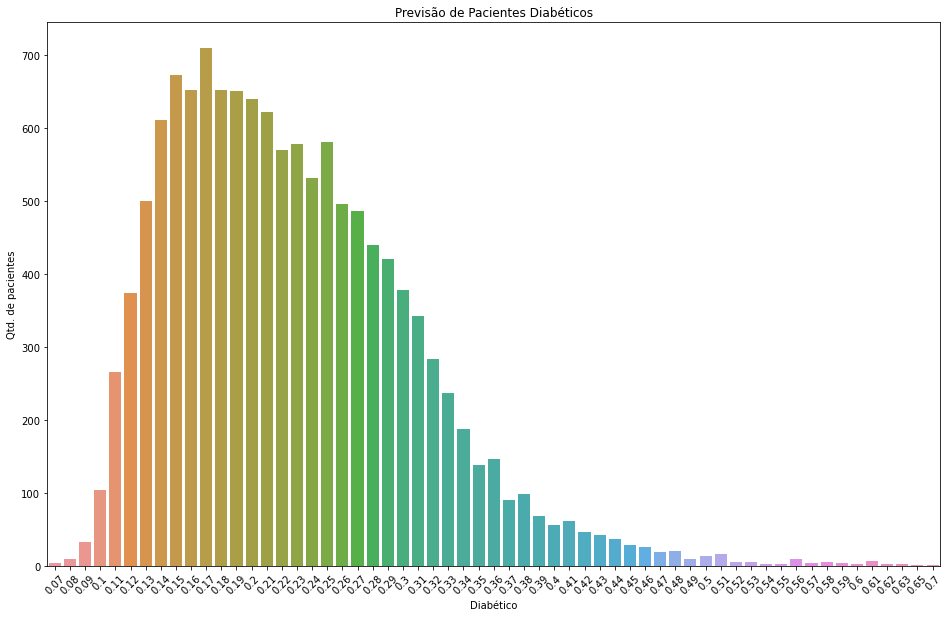

In [ ]:
# gera o df para submissão com base no template
result_logistic = get_dataframe_for_submission(logistic_model)
view_result(result_logistic)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_logistic, 'Teste 2 logistic regression')

100%|█████████████████████████████████████████| 338k/338k [00:03<00:00, 100kB/s]
400 - Bad Request


#### Random Forest
Treino do Modelo utilizando a algoritmo de Random Forest

****************** Random Forest ******************
Acurácia (Treino): 0.93
Acurácia (Teste): 0.82
              precision    recall  f1-score   support

          NO       0.84      0.95      0.89     22952
         YES       0.65      0.33      0.44      6334

    accuracy                           0.82     29286
   macro avg       0.74      0.64      0.66     29286
weighted avg       0.80      0.82      0.79     29286



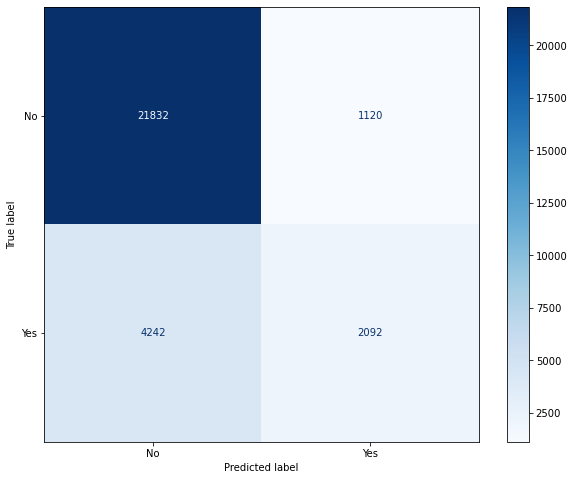

In [ ]:
print('****************** Random Forest ******************')

random_forest_model = create_random_forest_model(depth=16, estimators=100, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

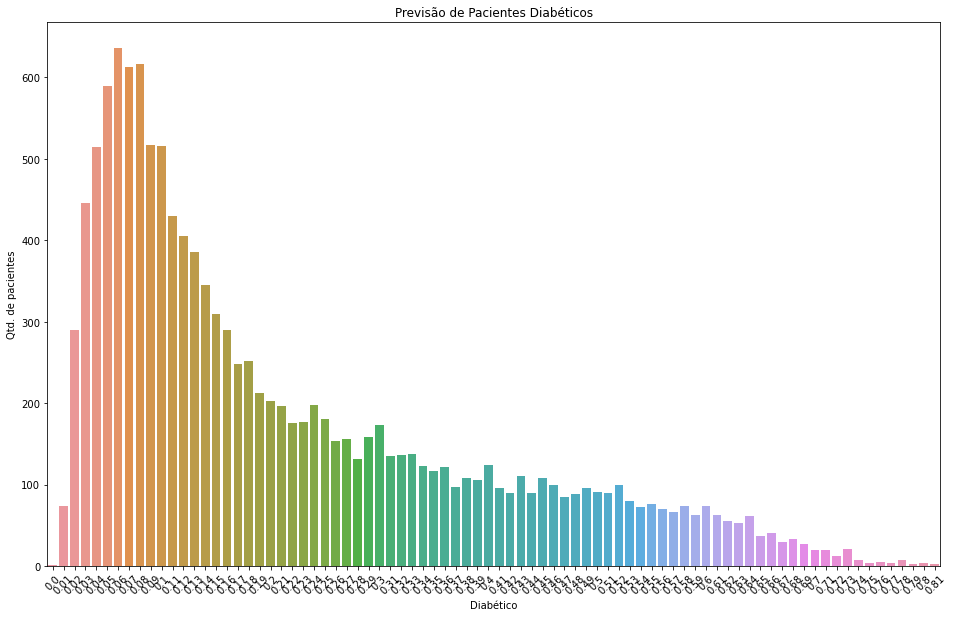

In [ ]:
result_random_forest = get_dataframe_for_submission(random_forest_model)
view_result(result_random_forest)

In [ ]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_random_forest, '9 Random Forest: depth=16, estimators=100')

### Ensemble Learning

Possible metrics to choose

In [ ]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [112]:
#@title Choose metric
work_metric = "roc_auc" #@param ["roc_auc", "accuracy"]

Functions to help Ensemble process

In [41]:
def create_ens_logistic_model():
  model = LogisticRegression()
  return model

def create_ens_decision_tree(depth):
  model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)
  return model

def create_ens_random_forest(depth, estimators):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  return model

def create_cross_validation_model(model, num_splits, scoring_metric, X_tr, y_tr):
  cv = KFold(n_splits = num_splits, 
            shuffle = True, 
            random_state=0)
  n_scores = cross_val_score(model, 
                            X_tr, y_tr, 
                            scoring = scoring_metric, 
                            cv = cv)
  print_cross_model_result(n_scores, scoring_metric)
  return model

def print_cross_model_result(n_scores, scoring_metric):
  print('Cross Validation Result\n')
  print(f'{scoring_metric}: {n_scores}\n')
  print(f'{scoring_metric} (média): {round(np.mean(n_scores), 4)}')
  print(f'{scoring_metric} (desvio padrão): {round(np.std(n_scores), 4)}')

def validate_ens_model(model, X_tr, X_ts, y_tr, y_ts):
  print('### Fit model ###')
  model.fit(X_tr, y_tr)
  print('### Result: ###')
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

#### Logistic Regression 

In [42]:
ens_logistic_model = LogisticRegression()

In [43]:
print('****************** ENSEMBLE Regressão Logística ******************')
ens_logistic_model = create_cross_validation_model(ens_logistic_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Regressão Logística ******************
Cross Validation Result

roc_auc: [0.8036221  0.80789281 0.80401673 0.81187666 0.81392994]

roc_auc (média): 0.8083
roc_auc (desvio padrão): 0.0041


### Fit model ###
### Result: ###
Acurácia (Treino): 0.74
Acurácia (Teste): 0.74
              precision    recall  f1-score   support

          NO       0.73      0.77      0.75     36723
         YES       0.76      0.71      0.73     36723

    accuracy                           0.74     73446
   macro avg       0.74      0.74      0.74     73446
weighted avg       0.74      0.74      0.74     73446



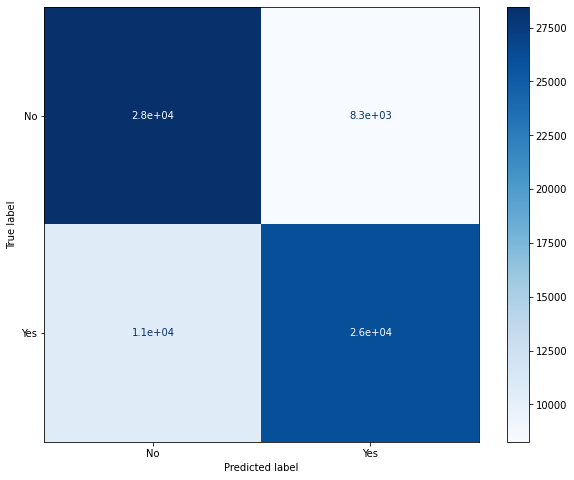

In [44]:
ens_logistic_model = validate_ens_model(ens_logistic_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


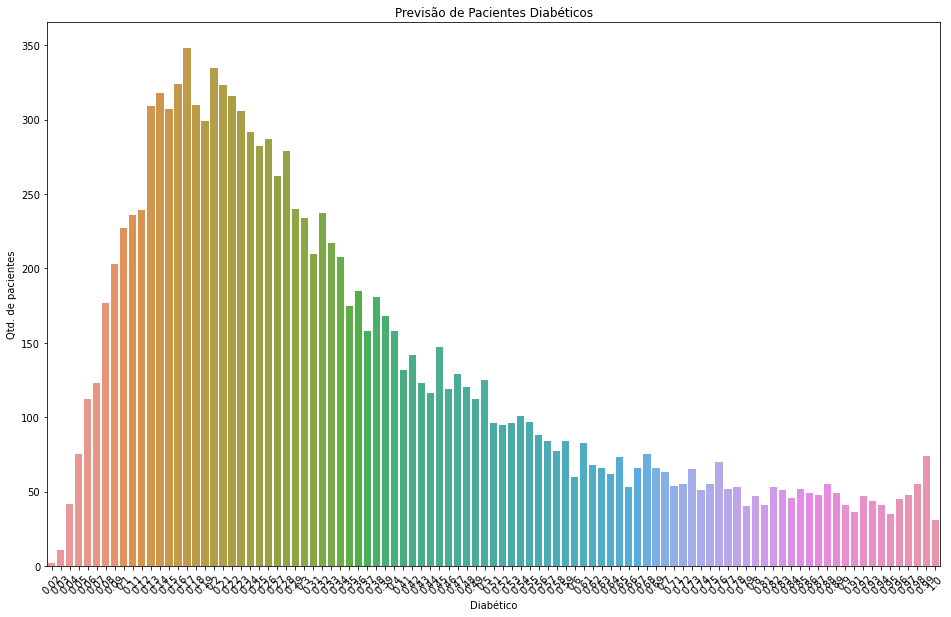

In [ ]:
result_logistic_ens = get_dataframe_for_submission(ens_logistic_model)
view_result(result_logistic_ens)

In [ ]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_logistic_ens, 'Ensemble 2 logistic regression')

#### Decision Tree

In [113]:
ens_tree_model = create_ens_decision_tree(20)

In [114]:
print('****************** ENSEMBLE Árvore de Decisão ******************')
ens_tree_model = create_cross_validation_model(ens_tree_model, 10, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Árvore de Decisão ******************
Cross Validation Result

roc_auc: [0.84410373 0.85165467 0.84447293 0.84974495 0.84607984 0.84725247
 0.84970735 0.85392483 0.84770384 0.85314408]

roc_auc (média): 0.8488
roc_auc (desvio padrão): 0.0033


### Fit model ###
### Result: ###
Acurácia (Treino): 0.93
Acurácia (Teste): 0.84
              precision    recall  f1-score   support

          NO       0.89      0.77      0.83     36723
         YES       0.80      0.91      0.85     36723

    accuracy                           0.84     73446
   macro avg       0.84      0.84      0.84     73446
weighted avg       0.84      0.84      0.84     73446



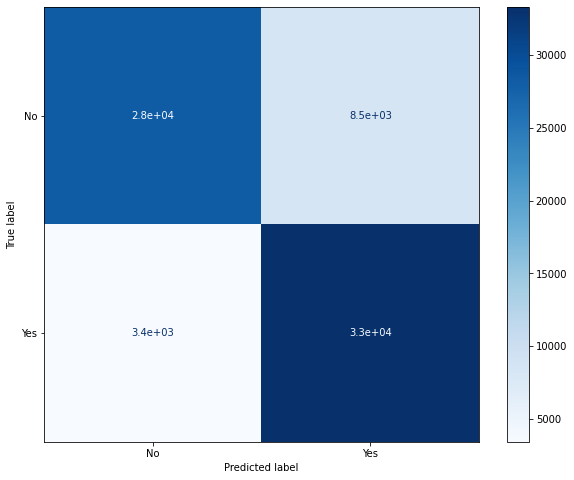

In [115]:
ens_tree_model = validate_ens_model(ens_tree_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


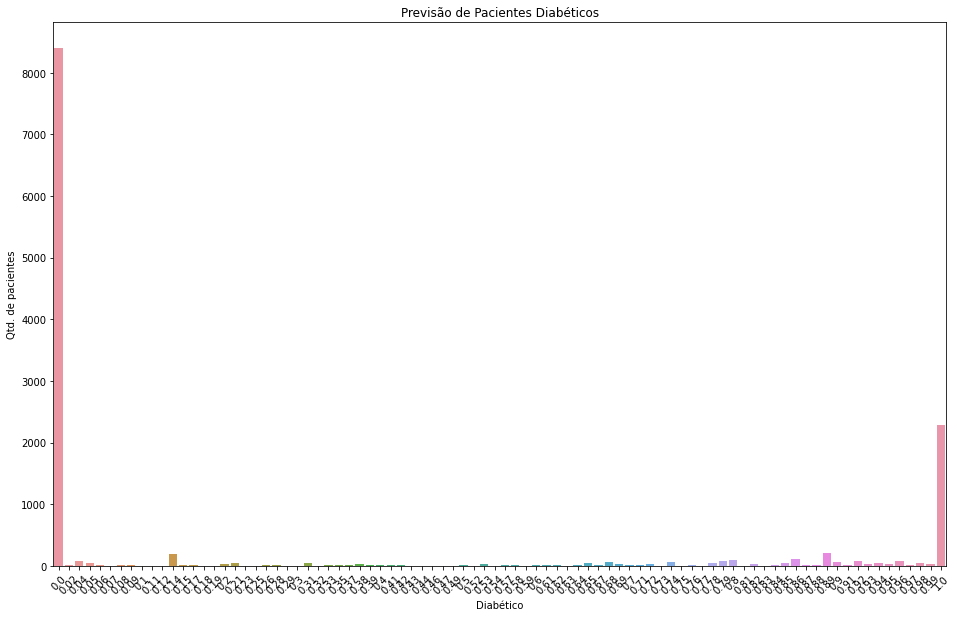

In [48]:
result_tree_ens = get_dataframe_for_submission(ens_tree_model)
view_result(result_tree_ens)

In [ ]:
# envia para o kagle o df com o resultado gerado
# send_submit(result_tree_ens, 'Ensemble 7 Decision Tree')

100% 182k/182k [00:00<00:00, 593kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Random Forest

In [243]:
ens_random_forest_model = create_ens_random_forest(16, 100)

In [244]:
print('****************** ENSEMBLE Random Forest ******************')
ens_random_forest_model = create_cross_validation_model(ens_random_forest_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Random Forest ******************
Cross Validation Result

roc_auc: [0.92652852 0.92251222 0.92131491 0.92603322 0.92217165]

roc_auc (média): 0.9237
roc_auc (desvio padrão): 0.0021


### Fit model ###
### Result: ###
Acurácia (Treino): 0.91
Acurácia (Teste): 0.85
              precision    recall  f1-score   support

          NO       0.89      0.80      0.85     27542
         YES       0.82      0.91      0.86     27543

    accuracy                           0.85     55085
   macro avg       0.86      0.85      0.85     55085
weighted avg       0.86      0.85      0.85     55085



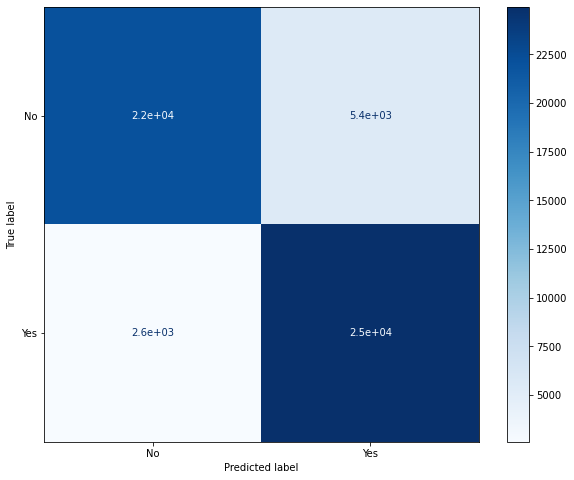

In [245]:
ens_random_forest_model = validate_ens_model(ens_random_forest_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


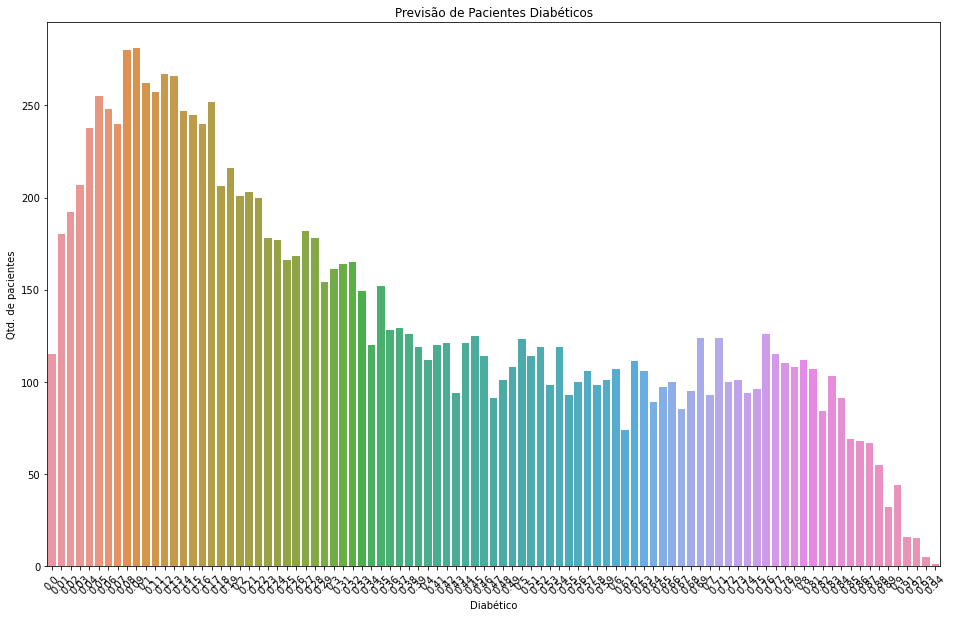

In [260]:
result_random_forest_ens = get_dataframe_for_submission(ens_random_forest_model)
view_result(result_random_forest_ens)

In [261]:
# envia para o kagle o df com o resultado gerado
send_submit(result_random_forest_ens, 'Ensemble 10 Random Forest: depth=16, estimators=100')

100% 337k/337k [00:05<00:00, 60.1kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Voting Classifier


##### Soft Voting

In [53]:
# metodos Ensemble Learning
# OBS hard não tem o predic_prob 
def get_voting_classifier(estimators, voting='soft'):
    return VotingClassifier(estimators = estimators, voting=voting)


In [54]:

soft_voting_model = get_voting_classifier([
                                          #  ('logistic_model', ens_logistic_model),
                                           ('tree_model', ens_tree_model),
                                           ('random_forest_model', ens_random_forest_model)], 'soft')

In [55]:
print('****************** ENSEMBLE Soft Voting Classifier ******************')
soft_voting_model = create_cross_validation_model(soft_voting_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Soft Voting Classifier ******************
Cross Validation Result

roc_auc: [0.93435569 0.93367492 0.93442905 0.93635558 0.93501065]

roc_auc (média): 0.9348
roc_auc (desvio padrão): 0.0009


### Fit model ###
### Result: ###
Acurácia (Treino): 0.97
Acurácia (Teste): 0.86
              precision    recall  f1-score   support

          NO       0.92      0.78      0.84     36723
         YES       0.81      0.94      0.87     36723

    accuracy                           0.86     73446
   macro avg       0.87      0.86      0.86     73446
weighted avg       0.87      0.86      0.86     73446



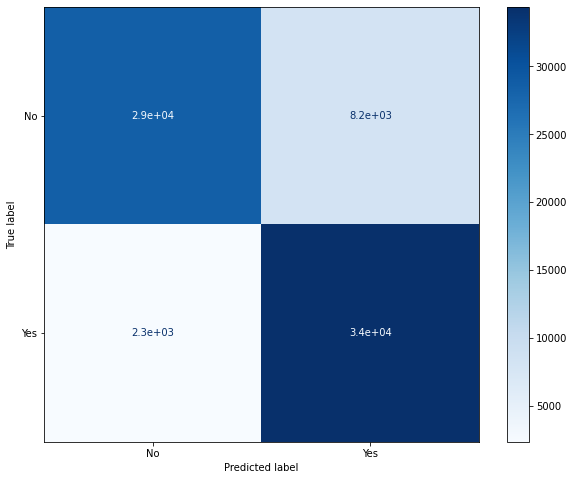

In [56]:
soft_voting_model = validate_ens_model(soft_voting_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


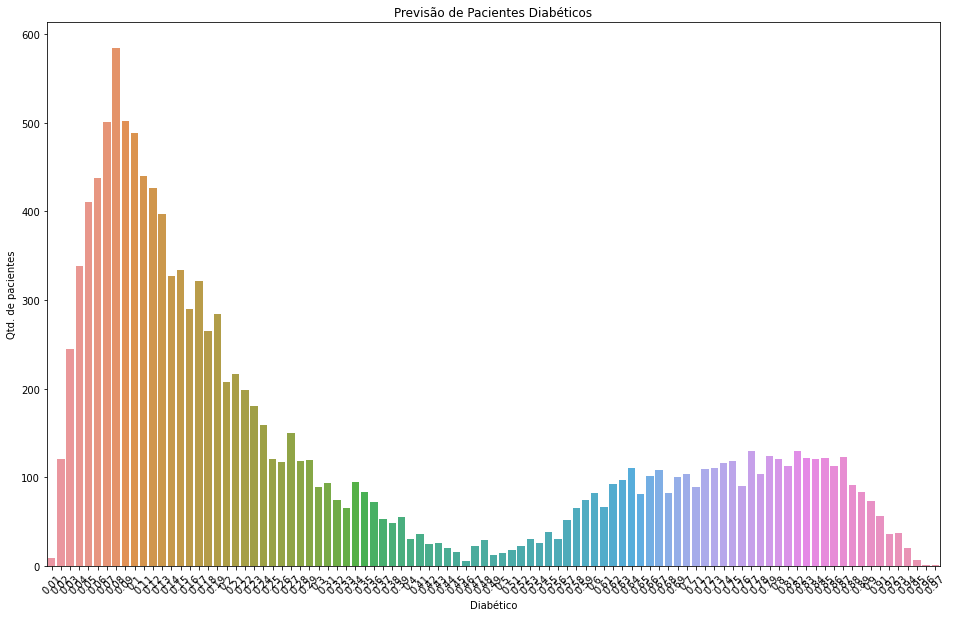

In [57]:
result_soft_voting = get_dataframe_for_submission(soft_voting_model)
view_result(result_soft_voting)

In [58]:
# envia para o kagle o df com o resultado gerado
send_submit(result_soft_voting, 'Ensemble 10 Soft Voting Classifier')

100% 337k/337k [00:03<00:00, 97.9kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Hard Voting

In [ ]:

hard_voting_model = get_voting_classifier([('tree_model', ens_tree_model),
                                           ('random_forest_model', ens_random_forest_model)], 'hard')

In [ ]:
print('****************** ENSEMBLE Hard Voting Classifier ******************')
hard_voting_model = create_cross_validation_model(hard_voting_model, 5, 'accuracy', X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Hard Voting Classifier ******************
Cross Validation Result

accuracy: [0.80957384 0.80640925 0.8058839  0.80693459 0.80923299]

accuracy (média): 0.8076
accuracy (desvio padrão): 0.0015


### Fit model ###
### Result: ###
Acurácia (Treino): 0.82
Acurácia (Teste): 0.81
              precision    recall  f1-score   support

          NO       0.83      0.95      0.89     32133
         YES       0.61      0.30      0.40      8867

    accuracy                           0.81     41000
   macro avg       0.72      0.62      0.64     41000
weighted avg       0.78      0.81      0.78     41000



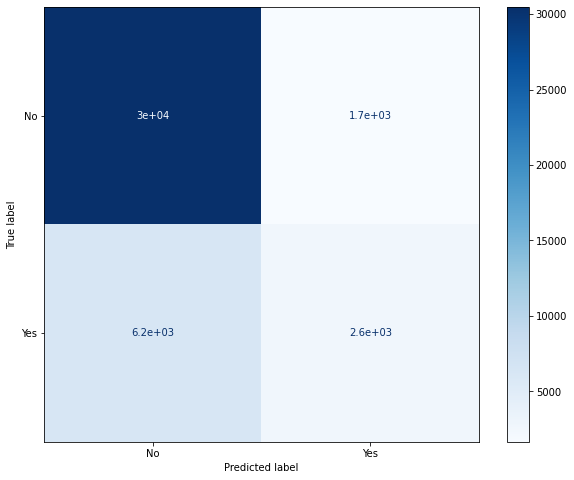

In [ ]:
hard_voting_model = validate_ens_model(hard_voting_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Hard... ###
### Create dataframe with result... ###


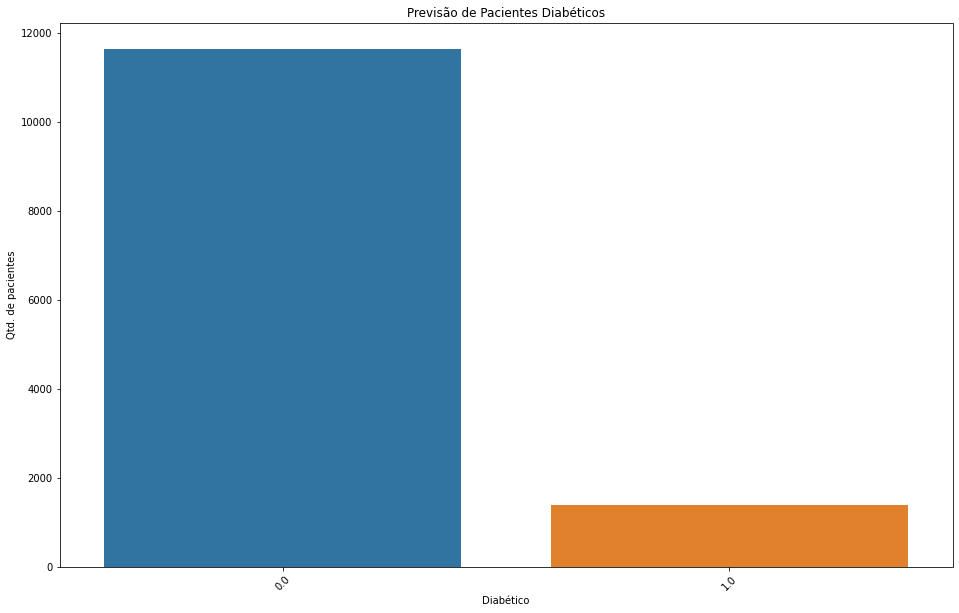

In [ ]:
result_hard_voting = get_dataframe_for_submission(hard_voting_model, prediction_type='predict')
view_result(result_hard_voting)

In [ ]:
# send_submit(result_soft_voting, 'Ensemble 2 Hard Voting Classifier')


#### Boost Methods

##### XGBoost

In [246]:
# XGBoost
xgb_model = xgboost.XGBClassifier(booster = 'gbtree', 
                                  learning_rate = 0.005,
                                  n_estimators = 100,
                                  max_depth = 15,
                                  random_state = 0)


In [247]:
print('****************** XGBoost ******************')
xgb_model = create_cross_validation_model(xgb_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** XGBoost ******************
Cross Validation Result

roc_auc: [0.89865186 0.90204844 0.89713171 0.90391714 0.89982695]

roc_auc (média): 0.9003
roc_auc (desvio padrão): 0.0024


### Fit model ###
### Result: ###
Acurácia (Treino): 0.91
Acurácia (Teste): 0.85
              precision    recall  f1-score   support

          NO       0.89      0.79      0.84     27542
         YES       0.81      0.90      0.85     27543

    accuracy                           0.85     55085
   macro avg       0.85      0.85      0.85     55085
weighted avg       0.85      0.85      0.85     55085



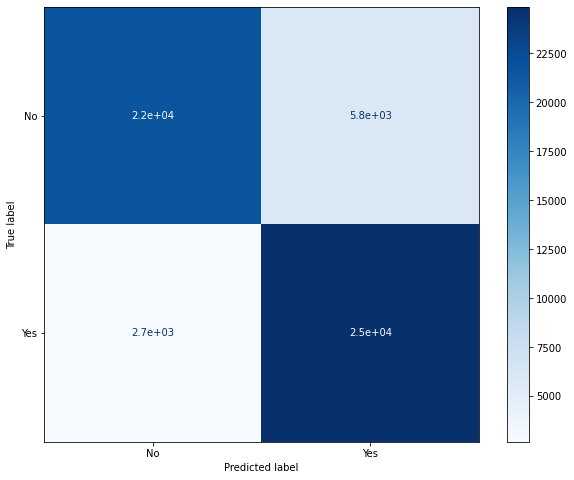

In [248]:
xgb_model = validate_ens_model(xgb_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


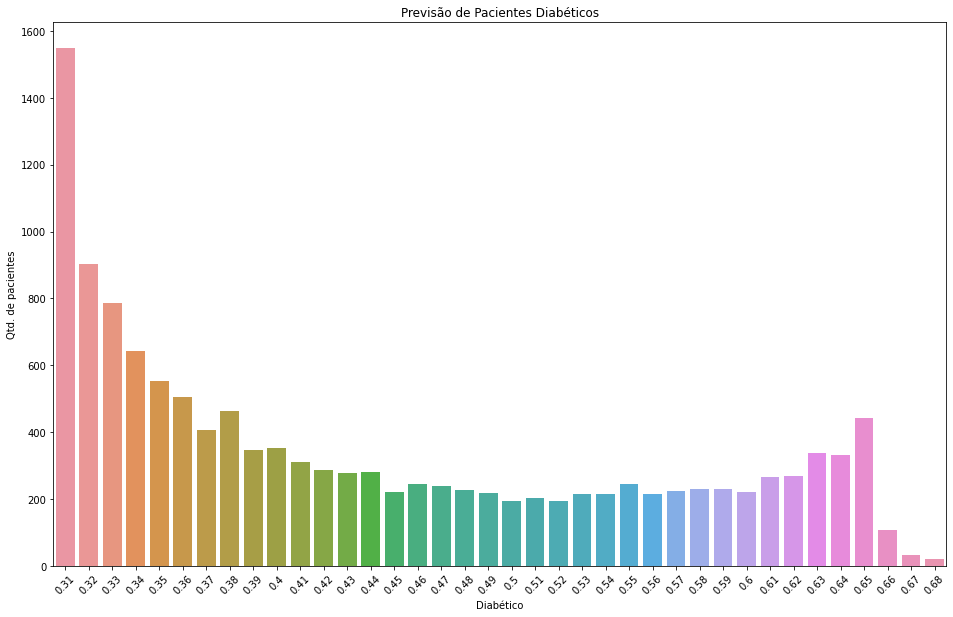

In [258]:
result_xgb_model = get_dataframe_for_submission(xgb_model)
view_result(result_xgb_model)

In [259]:
send_submit(result_xgb_model, 'XGBoost 3')

100% 333k/333k [00:05<00:00, 59.5kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

##### CatBoost

In [250]:
 cat_boost_model = catboost.CatBoostClassifier(iterations=5,
                         learning_rate=0.005,
                         depth=15,
                         random_state=0)

In [251]:
print('****************** CatBoost ******************')
cat_boost_model = create_cross_validation_model(cat_boost_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** CatBoost ******************
0:	learn: 0.6909610	total: 3.33s	remaining: 13.3s
1:	learn: 0.6887872	total: 6.04s	remaining: 9.06s
2:	learn: 0.6864360	total: 8.8s	remaining: 5.87s
3:	learn: 0.6842164	total: 11.5s	remaining: 2.88s
4:	learn: 0.6819482	total: 14.2s	remaining: 0us
0:	learn: 0.6910309	total: 2.8s	remaining: 11.2s
1:	learn: 0.6888862	total: 5.58s	remaining: 8.36s
2:	learn: 0.6866409	total: 8.29s	remaining: 5.53s
3:	learn: 0.6844755	total: 11s	remaining: 2.75s
4:	learn: 0.6822382	total: 13.7s	remaining: 0us
0:	learn: 0.6909296	total: 2.79s	remaining: 11.2s
1:	learn: 0.6887752	total: 5.5s	remaining: 8.26s
2:	learn: 0.6865279	total: 8.21s	remaining: 5.47s
3:	learn: 0.6843248	total: 10.9s	remaining: 2.73s
4:	learn: 0.6818960	total: 13.7s	remaining: 0us
0:	learn: 0.6909892	total: 2.7s	remaining: 10.8s
1:	learn: 0.6888226	total: 5.45s	remaining: 8.17s
2:	learn: 0.6866171	total: 8.17s	remaining: 5.45s
3:	learn: 0.6843241	total: 10.9s	remaining: 2.73s
4:	learn: 0.682

### Fit model ###
0:	learn: 0.6909430	total: 2.97s	remaining: 11.9s
1:	learn: 0.6887681	total: 5.74s	remaining: 8.61s
2:	learn: 0.6865384	total: 8.5s	remaining: 5.66s
3:	learn: 0.6843264	total: 11.3s	remaining: 2.82s
4:	learn: 0.6820638	total: 14.1s	remaining: 0us
### Result: ###
Acurácia (Treino): 0.77
Acurácia (Teste): 0.77
              precision    recall  f1-score   support

          NO       0.78      0.74      0.76     27542
         YES       0.76      0.79      0.77     27543

    accuracy                           0.77     55085
   macro avg       0.77      0.77      0.77     55085
weighted avg       0.77      0.77      0.77     55085



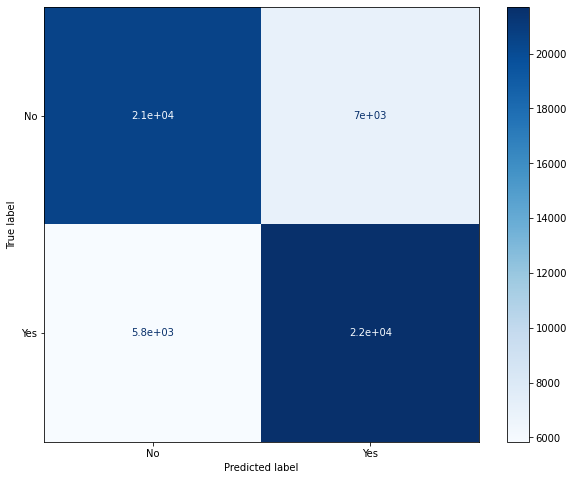

In [252]:
cat_boost_model = validate_ens_model(cat_boost_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


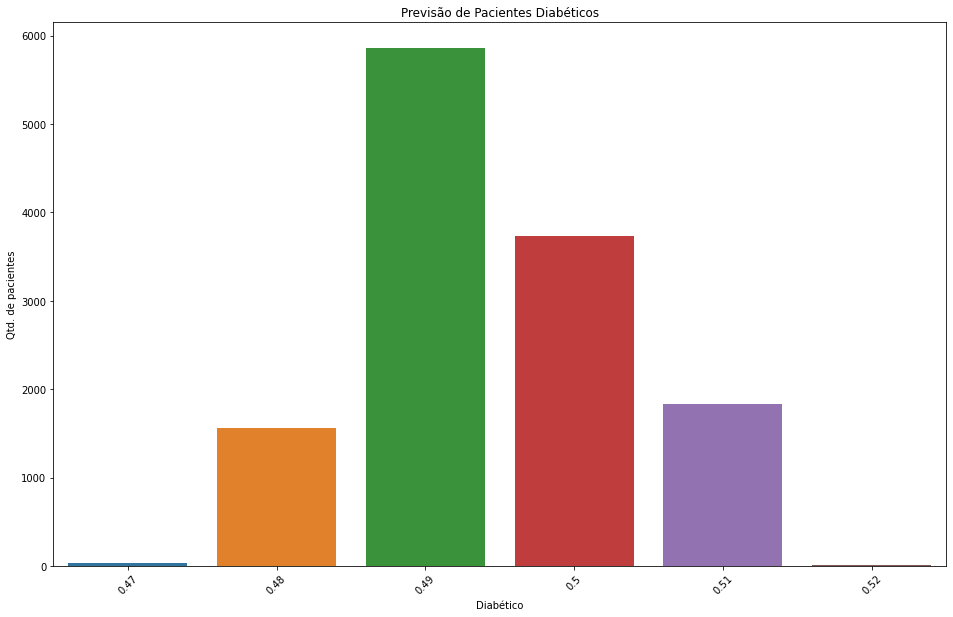

In [ ]:
result_cat_boost_model = get_dataframe_for_submission(cat_boost_model)
view_result(result_cat_boost_model)

In [ ]:
# send_submit(result_cat_boost_model, 'CatBoost')

####Combine Models that use soft vote




In [253]:
# Soft Models
soft_voting_all_models = get_voting_classifier([
    # ('logistic_model', ens_logistic_model),
    ('xgb_model', xgb_model),
    # ('tree_model', ens_tree_model),
    # ('cat_boost_model', cat_boost_model),
    ('random_forest_model', ens_random_forest_model)
    ], 'soft')

In [254]:
print('****************** ENSEMBLE Soft All Models Voting Classifier ******************')
soft_voting_all_models = create_cross_validation_model(soft_voting_all_models, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Soft All Models Voting Classifier ******************
Cross Validation Result

roc_auc: [0.92454744 0.92156453 0.91974818 0.92428992 0.9209739 ]

roc_auc (média): 0.9222
roc_auc (desvio padrão): 0.0019


### Fit model ###
### Result: ###
Acurácia (Treino): 0.91
Acurácia (Teste): 0.85
              precision    recall  f1-score   support

          NO       0.90      0.80      0.85     27542
         YES       0.82      0.91      0.86     27543

    accuracy                           0.85     55085
   macro avg       0.86      0.85      0.85     55085
weighted avg       0.86      0.85      0.85     55085



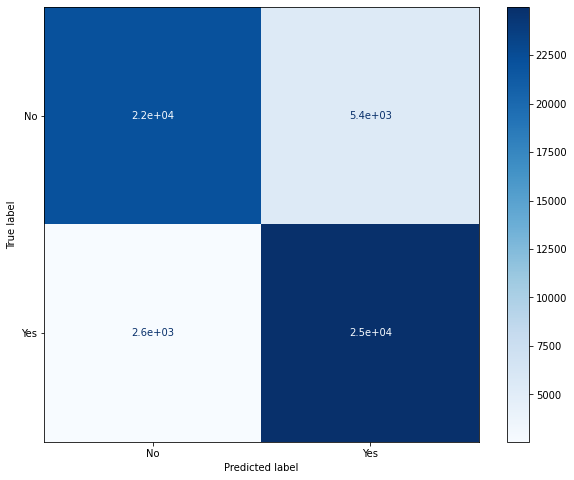

In [255]:
soft_voting_all_models = validate_ens_model(soft_voting_all_models, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

### Copy Template ###
### Filter encounter_id column ###
### Predict ... ###
### Proba... ###
### Create dataframe with result... ###


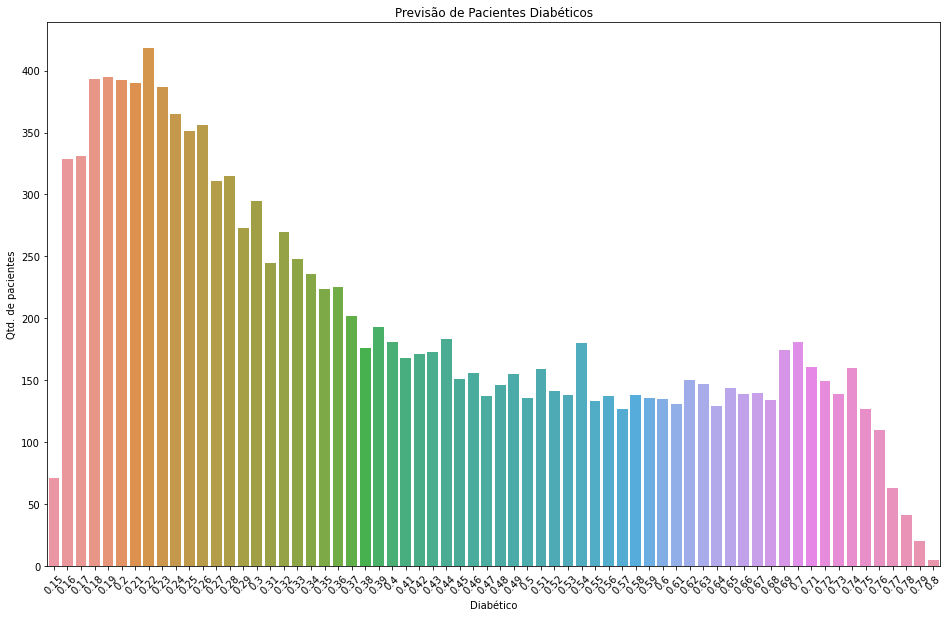

In [256]:
result_soft_voting_all_models = get_dataframe_for_submission(soft_voting_all_models)
view_result(result_soft_voting_all_models)

In [257]:
send_submit(result_soft_voting_all_models, 'Soft All Models 7')

100% 335k/335k [00:05<00:00, 60.8kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

### Redes Neurais

In [ ]:
# Perceptron model
perceptron_model = Perceptron(verbose=0)

In [ ]:
print('****************** Perceptron model Classifier ******************')
perceptron_model = create_cross_validation_model(perceptron_model, 3, work_metric, X_tr=X_train, y_tr=y_train)

****************** Perceptron model Classifier ******************
Cross Validation Result

roc_auc: [0.50057252 0.50742712 0.50835247]

roc_auc (média): 0.5055
roc_auc (desvio padrão): 0.0035


Acurácia (Treino): 0.78
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.78      1.00      0.88     22952
         YES       0.00      0.00      0.00      6334

    accuracy                           0.78     29286
   macro avg       0.39      0.50      0.44     29286
weighted avg       0.61      0.78      0.69     29286



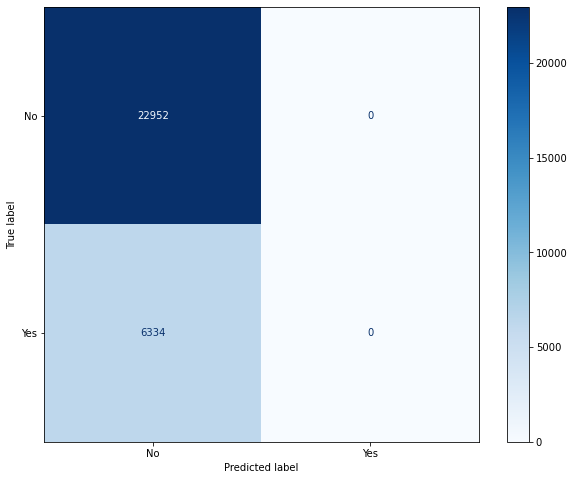

In [ ]:
result_perceptron_model = get_dataframe_for_submission(perceptron_model)

In [ ]:
# send_submit(result_perceptron_model, 'Perceptron model Classifier')

In [ ]:
#Multilayer Perceptron (Scikit-Learn)

mlp_model = MLPClassifier(max_iter=600,
                          random_state=0,
                          verbose=0)

In [ ]:
print('****************** Multilayer Perceptron model Classifier ******************')
mlp_model = create_cross_validation_model(mlp_model, 3, work_metric, X_tr=X_train, y_tr=y_train)

****************** Multilayer Perceptron model Classifier ******************
Cross Validation Result

roc_auc: [0.57029131 0.64663336 0.60019794]

roc_auc (média): 0.6057
roc_auc (desvio padrão): 0.0314


Acurácia (Treino): 0.78
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.78      1.00      0.88     22952
         YES       0.58      0.00      0.01      6334

    accuracy                           0.78     29286
   macro avg       0.68      0.50      0.44     29286
weighted avg       0.74      0.78      0.69     29286



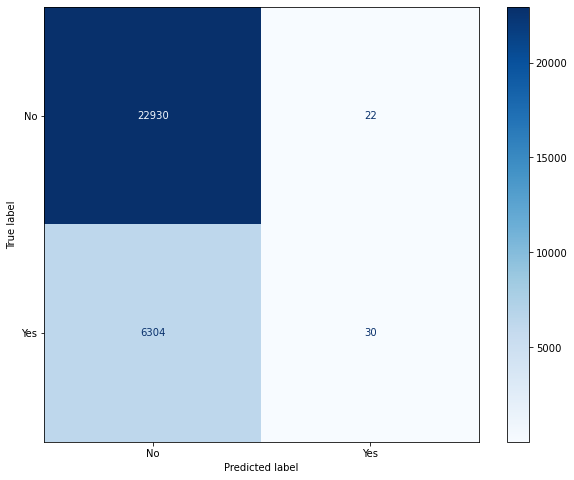

In [ ]:
mlp_model = validate_ens_model(mlp_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [ ]:
result_mlp_model = get_dataframe_for_submission(mlp_model)